In [1]:
import pandas as pd
%pylab inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble.forest import ForestClassifier, ForestRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, _tree

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_csv('dida_posey_to_predict.csv', index_col=0)
X = df[ 'CADD1,CADD2,RecA,EssA,CADD3,CADD4,RecB,EssB,Path'.split(',') ]
y = df['DE']
classes = df['Pair'][y != 'UK']
X = array(X[y != 'UK']).astype(np.float32)
y = y[y != 'UK']

In [3]:
from time import time

def _interpret_tree(tree, X, n_labels):
    
    # Tree preprocessing allowing down-top search
    
    parents = [-1 for _ in range(tree.node_count)]
    to_pursue = [0]
    while len(to_pursue):
        node_i = to_pursue.pop()
        child_l = tree.children_left[node_i]
        if child_l != _tree.TREE_LEAF:
            parents[child_l] = node_i
            child_r = tree.children_right[node_i]
            parents[child_r] = node_i
            to_pursue.append(child_l)
            to_pursue.append(child_r)
            
    # Values normalization -> probas
            
    values = tree.value.squeeze(axis=1)
    values /= values.sum(axis=1)[:, np.newaxis]
    
    n_features = len(X[0])
    
    f_contribs = [ zeros( (1, n_labels) ) for _ in range(n_features) ]
    biases = zeros( (1, n_labels) )
    f_indices = list(tree.feature)
    
    # For each sample to test, we check in which leaf it lands
    
    leaves = tree.apply(X)
    
    for leaf in leaves:
        cur_node = leaf
        while cur_node != -1:
            par_node = parents[cur_node]
            if par_node >= 0:
                resp_feature = f_indices[par_node]
                f_contribs[resp_feature] += (values[cur_node] - values[par_node])
            cur_node = par_node
        biases += values[leaf]
    f_contribs = [i/len(X) for i in f_contribs]
    biases /= len(X)
    
    return f_contribs, biases

def interpret_forest(forest, X, n_labels):
    f_contribs = [ zeros( (1, n_labels) ) for _ in range(len(X[0])) ]
    f_biases = 0
    for tree in map(lambda x: x.tree_, forest.estimators_):
        t_contribs, t_biases = _interpret_tree(tree, X, n_labels)
        f_contribs = [x + y/forest.n_estimators for x, y in zip(f_contribs, t_contribs)]
        f_biases += t_biases/forest.n_estimators
    return f_contribs, f_biases

In [4]:
from time import time

def _interpret_tree(tree, X, n_labels):
    
    # Tree preprocessing allowing down-top search
    
    parents = [-1 for _ in range(tree.node_count)]
    to_pursue = [0]
    while len(to_pursue):
        node_i = to_pursue.pop()
        child_l = tree.children_left[node_i]
        if child_l != _tree.TREE_LEAF:
            parents[child_l] = node_i
            child_r = tree.children_right[node_i]
            parents[child_r] = node_i
            to_pursue.append(child_l)
            to_pursue.append(child_r)
    
    # Values normalization -> probas
            
    values = tree.value.squeeze(axis=1)
    values /= values.sum(axis=1)[:, np.newaxis]
    
    n_features = len(X[0])
    
    f_contribs = [ zeros( (1, n_labels) ) for _ in range(n_features) ]
    biases = zeros( (1, n_labels) )
    f_indices = list(tree.feature)
    
    # For each sample to test, we check in which leaf it lands
    
    leaves = tree.apply(X)
    leaves_value = {}
    
    for leaf in leaves:
        if leaf not in leaves_value:
            l_contribs = [ zeros( (1, n_labels) ) for _ in range(n_features) ]
            cur_node = leaf
            while cur_node != -1:
                par_node = parents[cur_node]
                if par_node >= 0:
                    resp_feature = f_indices[par_node]
                    l_contribs[resp_feature] += (values[cur_node] - values[par_node])
                cur_node = par_node
            leaves_value[leaf] = l_contribs, values[leaf]
        l_contribs, l_bias = leaves_value[leaf]
        f_contribs = [f_i + c_i for f_i, c_i in zip(f_contribs, l_contribs) ]
        biases += l_bias
    f_contribs = [i/len(X) for i in f_contribs]
    biases /= len(X)
    
    return f_contribs, biases

def interpret_forest(forest, X, n_labels):
    f_contribs = [ zeros( (1, n_labels) ) for _ in range(len(X[0])) ]
    f_biases = 0
    for tree in map(lambda x: x.tree_, forest.estimators_):
        t_contribs, t_biases = _interpret_tree(tree, X, n_labels)
        f_contribs = [x + y/forest.n_estimators for x, y in zip(f_contribs, t_contribs)]
        f_biases += t_biases/forest.n_estimators
    return f_contribs, f_biases

In [5]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
all_contribs = {
    name: zeros( (3, 9) )
    for name in ('CO', 'DD', 'TD')
}
clf = RandomForestClassifier(max_depth=10,criterion='gini').fit(X, y)
for train_is, test_is in logo.split(X, y, classes):
    
    clf.fit(X[train_is], y[train_is])
    contribs, bias = interpret_forest(clf, X[test_is], 3)
    label = y[test_is][0]
    for i in range(9):
        for j in range(3):
            all_contribs[label][j,i] += contribs[i][0][j]

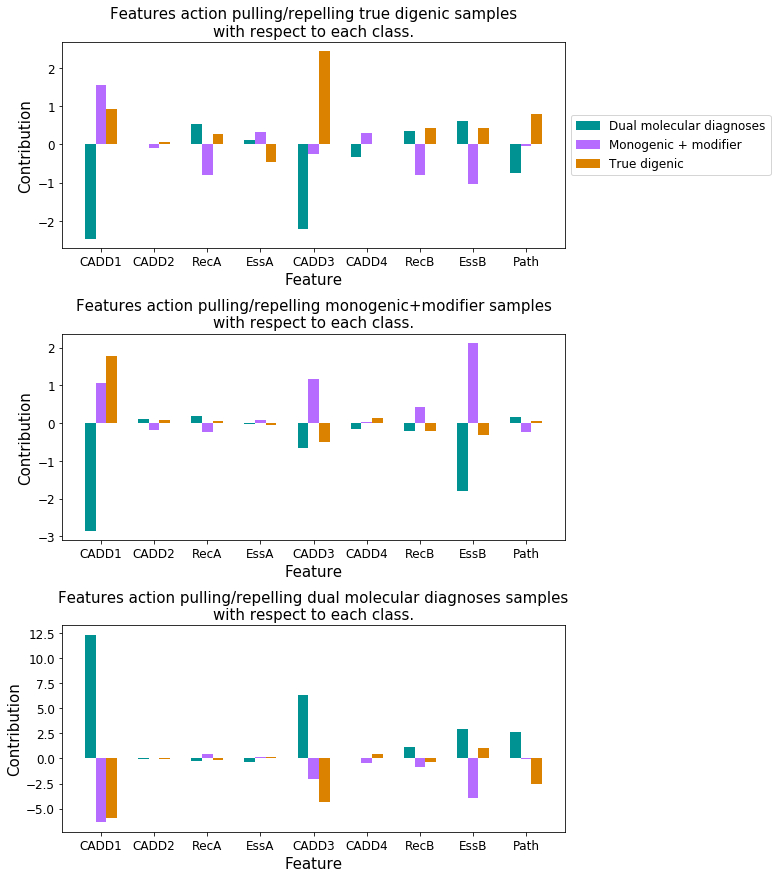

In [10]:
figsize(10, 20)
width = 1/45
xs = arange(9) / 9

fig, _ = subplots(3, 1, figsize=(8,12))
features = "CADD1,CADD2,RecA,EssA,CADD3,CADD4,RecB,EssB,Path".split(',')

for i, l, t in zip( range(3), ('CO', 'TD', 'DD'), ('true digenic', 'monogenic+modifier', 'dual molecular diagnoses') ):
    
    subplot(3,1,i+1)
    tight_layout()
    
    contrib = all_contribs[l]

    results_co = contrib[0]
    results_dd = contrib[1]
    results_td = contrib[2]

    bar(xs, results_dd, width, color=(0/255, 146/255, 146/255, 1), label="Dual molecular diagnoses", bottom=10e-5)
    bar(xs + width, results_td, width, color=(182/255, 109/255, 255/255, 1), label="Monogenic + modifier", bottom=10e-5)
    bar(xs + 2*width, results_co, width, color=(219/255, 130/255, 0/255, 1), label="True digenic", bottom=10e-5)

    yticks(fontsize=12)
    xticks(xs + width, features, fontsize=12)
    xlabel('Feature', fontsize=15)
    ylabel('Contribution', fontsize=15)
    if i == 0:
        legend(prop={'size': 12}, loc='center left', bbox_to_anchor=(1, 0.5))
    title(f'Features action pulling/repelling {t} samples\nwith respect to each class.', fontsize=15)
    savefig('contribution_new.png', format='png', bbox_inches='tight')
    savefig('contribution_new.eps', format='eps', bbox_inches='tight')

In [7]:
all_contribs

{'CO': array([[ 0.91919566,  0.07009794,  0.26285255, -0.45348217,  2.44387685,
          0.01810341,  0.43359873,  0.41954832,  0.78918738],
        [-2.47380173,  0.02086377,  0.52962659,  0.12964607, -2.20743988,
         -0.32122528,  0.36455009,  0.60619911, -0.75108064],
        [ 1.55460607, -0.09096172, -0.79247914,  0.3238361 , -0.23643697,
          0.30312187, -0.79814881, -1.02574743, -0.03810674]]),
 'DD': array([[-5.98371432e+00, -7.87639536e-02, -1.68057610e-01,
          1.98405489e-01, -4.32500339e+00,  4.13432336e-01,
         -3.61197388e-01,  1.01562877e+00, -2.53361571e+00],
        [ 1.23682622e+01, -1.14172222e-02, -2.36873235e-01,
         -3.36595561e-01,  6.39042206e+00,  1.59779375e-02,
          1.19431017e+00,  2.93047146e+00,  2.60100726e+00],
        [-6.38454790e+00,  9.01811757e-02,  4.04930845e-01,
          1.38190072e-01, -2.06541868e+00, -4.29410274e-01,
         -8.33112777e-01, -3.94610022e+00, -6.73915525e-02]]),
 'TD': array([[ 1.77451151,  0.07

In [8]:
len(classes)

240